In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import pyro
import warnings
from typing import List, Tuple
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from tqdm.autonotebook import tqdm
# labelsize 18, fontsize 14, legend fontsize 14
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size": 18})
rc("text", usetex=True)

sys.path.append("../../../")
warnings.filterwarnings("ignore")

from bannane.src.config import Config
from bannane.src.data_loader import MultiIsotopeDataLoader
from bannane.src.preprocess import split_data_multi_isotope, preprocess_data_multi_isotope
from bannane.src.model import HierarchicalBNN
from bannane.src.trainer import Trainer, bannane_inference
from bannane.src.plotting import plot_training_losses_history, plot_mape_history


# Training a BANNANE Emulator

## Training the model

Lets set up the folders to store the data and the model.

In [ ]:
logs_dir = '../../../_results/objects'
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

config = Config()

config.data_directory = '../../DATA/all_o'
config.file_pattern = "*_radii.csv"

config.model_save_path = logs_dir + '/model.pth'
config.temperature_save_path = logs_dir + '/temperature.pth'
config.scaler_X_path = logs_dir + '/scaler_X.pth'
config.scaler_y_path = logs_dir + '/scaler_y.pth'

config.patience = 200
config.lr_patience = 25
config.lr_decay = 2.

config.shared_latent_dim = 128
config.hidden_dim = 64

config.num_heads = 2
config.fidelity_embedding_dim = 8

config.num_iterations = 30_000
config.dropout = 0.1
config.learning_rate = 1e-4

config.loss_weights = {4: 1.0, 6: 1.5, 8: 2.0, 10: 2.5}

In [3]:
# 1) Initialize configuration and seeds
torch.manual_seed(config.seed)
np.random.seed(config.seed)
pyro.set_rng_seed(config.seed)

# 2) Load the full dataset
loader = MultiIsotopeDataLoader(config)
full_data = loader.load_all_data()

# 3) Split into training, validation, and test sets
train_df, val_df, test_df = split_data_multi_isotope(full_data, config)

# 4) Preprocess data for each split
train_datasets, scaler_X, scaler_y = preprocess_data_multi_isotope(train_df, config)
val_datasets, _, _ = preprocess_data_multi_isotope(val_df, config)
test_datasets, _, _ = preprocess_data_multi_isotope(test_df, config)

# 5) Determine fidelity levels
fidelity_levels = sorted(full_data[config.fidelity_col].unique())
print(f"[Main] Fidelity levels: {fidelity_levels}")

# 6) Initialize model and trainer
bnn_model = HierarchicalBNN(config, fidelity_levels).to(config.device)
trainer = Trainer(bnn_model, config)

# 7) Train the model
histories = trainer.train(train_datasets, fidelity_levels, val_datasets)

# 8) Load the best model from disk
best_model = HierarchicalBNN.load(config.model_save_path, config, fidelity_levels, device=config.device).to(config.device)


[DataLoader] Found 13 files matching the pattern.
[DataLoader] Combined data shape: (17234, 35)
[Preprocess] Data split => train: (11029, 35), val: (2758, 35), test: (3447, 35)
[Preprocess] Processed fidelity 4 (index 0): 3882 samples.
[Preprocess] Processed fidelity 6 (index 1): 3318 samples.
[Preprocess] Processed fidelity 8 (index 2): 3154 samples.
[Preprocess] Processed fidelity 10 (index 3): 675 samples.
[Preprocess] Processed fidelity 4 (index 0): 913 samples.
[Preprocess] Processed fidelity 6 (index 1): 860 samples.
[Preprocess] Processed fidelity 8 (index 2): 773 samples.
[Preprocess] Processed fidelity 10 (index 3): 212 samples.
[Preprocess] Processed fidelity 4 (index 0): 1112 samples.
[Preprocess] Processed fidelity 6 (index 1): 1090 samples.
[Preprocess] Processed fidelity 8 (index 2): 1026 samples.
[Preprocess] Processed fidelity 10 (index 3): 219 samples.
[Main] Fidelity levels: [4, 6, 8, 10]
[Trainer] Starting BNN training...


Training BNN:   0%|          | 0/30000 [00:00<?, ?it/s]

[Trainer] No improvement. Iteration 7400. Early stopping counter: 1, LR counter: 1
[Trainer] No improvement. Iteration 7500. Early stopping counter: 2, LR counter: 2
[Trainer] No improvement. Iteration 7600. Early stopping counter: 3, LR counter: 3
[Trainer] No improvement. Iteration 7700. Early stopping counter: 4, LR counter: 4
[Trainer] No improvement. Iteration 7800. Early stopping counter: 5, LR counter: 5
[Trainer] No improvement. Iteration 7900. Early stopping counter: 6, LR counter: 6
[Trainer] No improvement. Iteration 8100. Early stopping counter: 1, LR counter: 1
[Trainer] No improvement. Iteration 8300. Early stopping counter: 1, LR counter: 1
[Trainer] No improvement. Iteration 8600. Early stopping counter: 1, LR counter: 1
[Trainer] No improvement. Iteration 8700. Early stopping counter: 2, LR counter: 2
[Trainer] No improvement. Iteration 8800. Early stopping counter: 3, LR counter: 3
[Trainer] No improvement. Iteration 9000. Early stopping counter: 1, LR counter: 1
[Tra

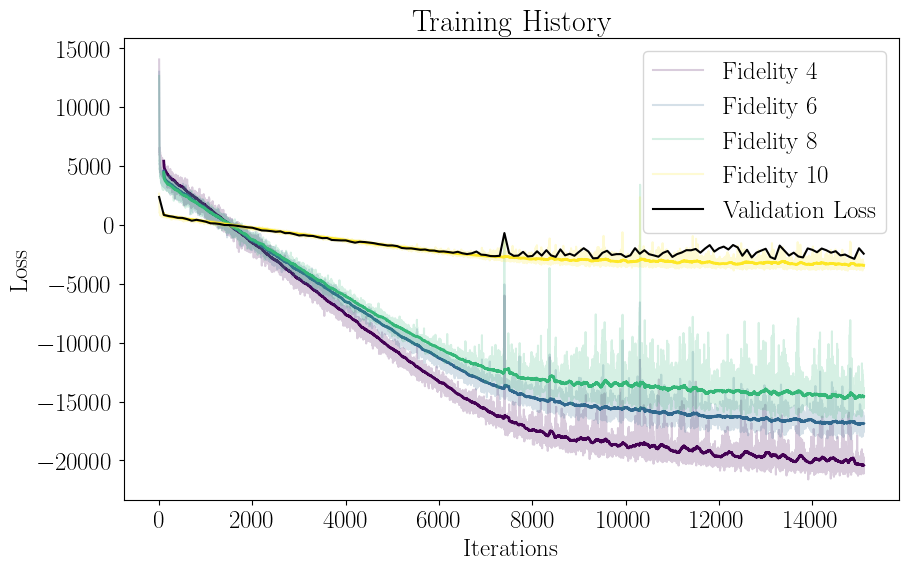

In [4]:
plot_training_losses_history(histories)

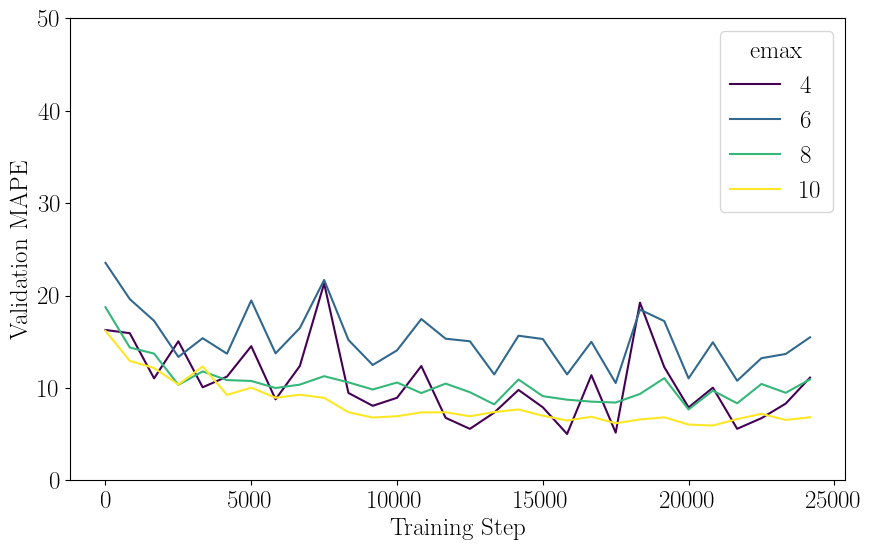

In [5]:
plot_mape_history(histories)

In [6]:
validation_data = test_df[(test_df['Z'] == 8) & (test_df[config.fidelity_col] == 10)]
groups = validation_data.groupby(['Z', 'N'])
results = []
n_bootstrap = 1000

for (Z, N), group in groups:
    isotope = f"{Z+N}O"  # Example isotope notation
    x = group[config.input_cols].values
    y_true = group[config.target_cols].values

    if len(x) == 0:
        continue

    y_pred, y_unc = bannane_inference(
        x,
        fidelity=10,
        Z=Z,
        N=N,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        trainer=trainer,
        config=config,
        return_unc=True
    )
    residuals = y_pred - y_true
    rmse_target0 = np.sqrt(np.mean(residuals[:, 0] ** 2))
    rmse_target1 = np.sqrt(np.mean(residuals[:, 1] ** 2))

    bootstrap_rmse0 = []
    bootstrap_rmse1 = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(residuals), len(residuals))
        sample = residuals[indices]
        bootstrap_rmse0.append(np.sqrt(np.mean(sample[:, 0] ** 2)))
        bootstrap_rmse1.append(np.sqrt(np.mean(sample[:, 1] ** 2)))
    uncertainty0 = np.std(bootstrap_rmse0)
    uncertainty1 = np.std(bootstrap_rmse1)

    results.append({
        'Isotope': isotope,
        'Z': Z,
        'N': N,
        'RMSE_target0': rmse_target0,
        'RMSE_target0_uncertainty': uncertainty0,
        'RMSE_target1': rmse_target1,
        'RMSE_target1_uncertainty': uncertainty1,
    })

pd.DataFrame(results)


,Isotope,Z,N,RMSE_target0,RMSE_target0_uncertainty,RMSE_target1,RMSE_target1_uncertainty
0,12O,8,4,0.436162,0.088657,0.024266,0.003894
1,13O,8,5,0.642359,0.114809,0.005776,0.001368
2,14O,8,6,0.926334,0.150666,0.016630,0.002171
3,15O,8,7,1.193907,0.180321,0.024351,0.002917
4,16O,8,8,1.573351,0.411688,0.022711,0.004681
5,17O,8,9,0.540307,0.086123,0.009844,0.001810
6,18O,8,10,0.918059,0.184794,0.008562,0.001121
7,19O,8,11,0.621250,0.085601,0.009775,0.001424
8,20O,8,12,0.455080,0.076436,0.008910,0.001167
9,21O,8,13,0.573102,0.122266,0.009093,0.001350


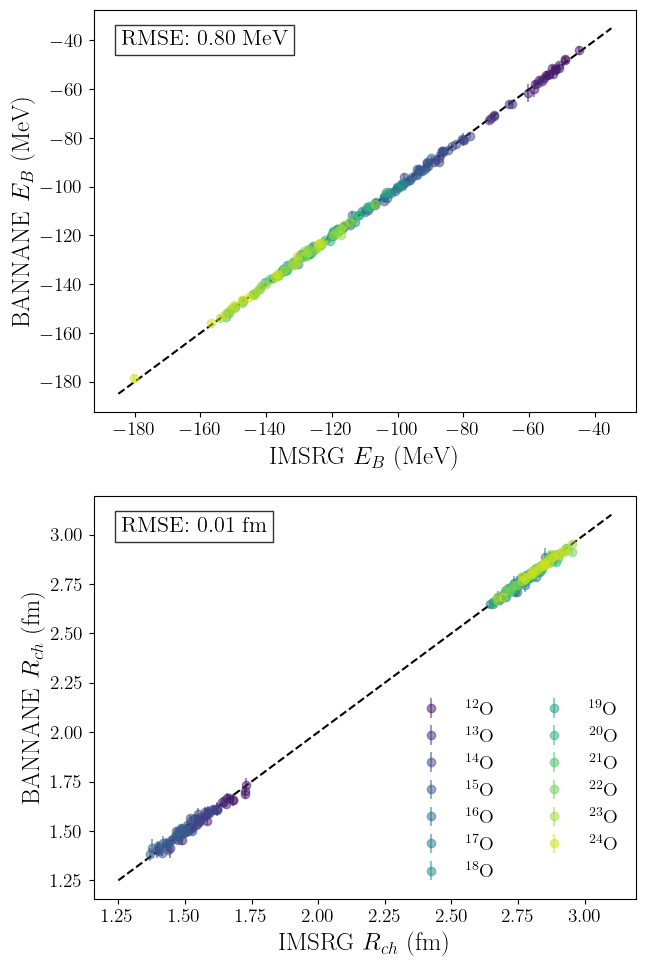

In [7]:
target_emax = 10
fig, (ax_energy, ax_radii) = plt.subplots(2, 1, figsize=(8, 10))
oxygen_groups = val_df[val_df['Z'] == 8].groupby(['Z', 'N'])
colors = sns.color_palette("viridis", len(oxygen_groups))
energy_errors = []
radii_errors = []
for ((Z_val, N_val), group), col in zip(oxygen_groups, colors):
    isotope_label = f"$^{{{Z_val+N_val}}}$O"
    sub_df = group[group[config.fidelity_col] == target_emax]
    if sub_df.empty:
        continue
    x_vals = sub_df[config.input_cols].values
    y_true_vals = sub_df[config.target_cols].values
    y_pred_vals, y_unc_vals = bannane_inference(
        x_vals,
        fidelity=target_emax,
        Z=Z_val,
        N=N_val,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        trainer=trainer,
        config=config,
        return_unc=True
    )
    energy_errors.append(y_pred_vals[:, 0] - y_true_vals[:, 0])
    radii_errors.append(y_pred_vals[:, 1] - y_true_vals[:, 1])

    ax_energy.errorbar(
        y_true_vals[:, 0],
        y_pred_vals[:, 0],
        yerr=y_unc_vals[:, 0],
        fmt='o',
        alpha=0.5,
        label=isotope_label,
        color=col
    )
    ax_radii.errorbar(
        y_true_vals[:, 1],
        y_pred_vals[:, 1],
        yerr=y_unc_vals[:, 1],
        fmt='o',
        alpha=0.5,
        label=isotope_label,
        color=col
    )

if energy_errors:
    all_energy_errors = np.concatenate(energy_errors)
    energy_rmse = np.sqrt(np.mean(all_energy_errors**2))
else:
    energy_rmse = np.nan
if radii_errors:
    all_radii_errors = np.concatenate(radii_errors)
    radii_rmse = np.sqrt(np.mean(all_radii_errors**2))
else:
    radii_rmse = np.nan

ax_energy.plot([-185, -35], [-185, -35], 'k--', label=None)
ax_energy.set_xlabel("IMSRG $E_{B}$ (MeV)", fontsize=18)
ax_energy.set_ylabel("BANNANE $E_{B}$ (MeV)", fontsize=18)
ax_energy.text(0.05, 0.95, f'RMSE: {energy_rmse:.2f} MeV',
               transform=ax_energy.transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8),
               fontsize=16)

ax_radii.plot([1.25, 3.1], [1.25, 3.1], 'k--', label=None)
ax_radii.set_xlabel("IMSRG $R_{ch}$ (fm)", fontsize=18)
ax_radii.set_ylabel("BANNANE $R_{ch}$ (fm)", fontsize=18)
ax_radii.tick_params(axis='both', which='major', labelsize=14)
ax_energy.tick_params(axis='both', which='major', labelsize=14)
ax_radii.text(0.05, 0.95, f'RMSE: {radii_rmse:.2f} fm',
              transform=ax_radii.transAxes,
              verticalalignment='top',
              bbox=dict(facecolor='white', alpha=0.8),
              fontsize=16)

handles, labels = ax_energy.get_legend_handles_labels()
ax_radii.legend(handles, labels, loc='lower right', ncol=2, fontsize=14, frameon=False)#, title="Isotope", title_fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("predictions_vs_true_energy_radii.pdf", bbox_inches='tight')
plt.show()

# LEC Sampling

In [9]:
samples_df = pd.read_csv('../../DATA/8000Samples.txt', sep='\t')

# We need to 'SampleID' in the samples_df to 'Sample' in the all_data. It is an unique identifier for each sample.
samples_df.rename(columns={'SampleID': 'Sample'}, inplace=True)
samples_df['weight'] = samples_df["A2-4,16likelihood"] / \
    samples_df["A2-4,16likelihood"].sum()

In [10]:
def all_preds_for_ids(all_samles, sample_ids: List[int], N, y_var: int = 0, emax: int = 8):
    x_samples = all_samles[all_samles["Sample"].isin(sample_ids)][config.input_cols].values
    preds, uncs = bannane_inference(
        x_samples,
        fidelity=emax,
        Z=8,
        N=N,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        trainer=trainer,
        config=config,
        return_unc=True
    )
    return preds[:, y_var], uncs[:, y_var]

def weighted_avg_pred(N, emax=8, y_var=0):
    preds, uncs = all_preds_for_ids(samples_df, samples_df["Sample"].values, N, emax=emax, y_var=y_var)
    return preds, uncs

In [11]:
def compute_pdf(df, observable, samples,  error_model=None, error_method=None, error_emulator=None, error_operator=None):
  rng = np.random.default_rng(1)
  size_samples = samples.size
  error_model_arr = np.zeros(size_samples)
  error_method_arr = np.zeros(size_samples)
  error_emulator_arr = np.zeros(size_samples)
  error_operator_arr = np.zeros(size_samples)
  if type(error_model) is float or type(error_model) is np.ndarray:
      error_model_arr = rng.normal(scale=error_model, size=size_samples)
  if type(error_method) is float or type(error_method) is np.ndarray:
      error_method_arr = rng.normal(scale=error_method, size=size_samples)
  if type(error_emulator) is float or type(error_emulator) is np.ndarray:
    error_emulator_arr = rng.normal(scale=error_emulator, size=size_samples)
  if type(error_operator) is float or type(error_operator) is np.ndarray:
    error_operator_arr = rng.normal(scale=error_operator, size=size_samples)
  error = error_model_arr+error_method_arr+error_emulator_arr+error_operator_arr
  vals = df[observable][samples]+error
  samples_val = np.array(vals)
  sum_obs = np.sum(samples_val)
  mean = sum_obs/size_samples
  return mean, samples_val

def find_confidence_interval(x , y, value=0.68):
  delta_x = x[1]-x[0]
  I = y/2*delta_x
  count=1
  I = I[1:]+I[:-1]
  I1 = I.copy()
  while True:
    I = I1[count:]+I[:-1]
    count += 1
    Iconv = I.copy()
    Iconv[Iconv<value] = 0
    if Iconv.any():
      break
  xminindex = np.argmax(Iconv)
  xmaxindex = xminindex+count+1
  xmin = x[xminindex]
  xmax = x[xmaxindex]
  return xmin, xmax

def get_dob(df, observable, samples, error_model=None, error_method=None, error_emulator=None, error_operator=None, confint=0.68, nbins=1000,  verbose=False):
    mean, samples_val = compute_pdf(df, observable, samples, error_model=error_model, error_method=error_method, error_emulator=error_emulator, error_operator= error_operator)
    height, bins = np.histogram(samples_val, bins=nbins, density=True)
    xmin, xmax = find_confidence_interval(bins, height, value=confint)
    if verbose:
        print(mean)
        print(bins[np.argmax(height)])
        print(xmin, xmax)
    return mean, xmin, xmax

def plot_posterior_pdf_hist(ax, df, observable, samples,
                            error_model=None,
                            error_method=None,
                            error_emulator=None,
                            error_operator=None,
                            confint=0.68, nbins=100,
                            experiment=None,
                            exp_label='Exp.',
                            add_exp_label=True,
                            add_conf_label=True,
                            color='b', verbose=True,
                            legend=True,
                            histogram_name = 'Posterior PDF',
                            xlabel='Observable',
                            ylabel='Density',
                            added_text_box="",
                            ):
  mean, samples_val = compute_pdf(df, observable, samples, error_model=error_model,
                                  error_method=error_method, error_emulator=error_emulator, error_operator=error_operator)

  height, bins, patches = ax.hist(samples_val, bins=nbins, density=True,
                                  label=histogram_name,
                                  alpha=0.8, color=color, stacked=True)
  xmin, xmax = find_confidence_interval(bins, height, confint)
  if verbose:
     print(mean, bins[np.argmax(height)], xmin, xmax)
  ax.axvspan(xmin, xmax, color=color, alpha=0.1,
             label=f"{int(confint*100)}% degree of belief interval" if add_conf_label else None)
  if experiment and (experiment[0] != experiment[1]):
    ax.axvspan(experiment[0], experiment[1], alpha=0.3, color='red', label=None)
  if add_exp_label and experiment and (experiment[0] == experiment[1]):
    ax.axvline(experiment[0], color='black', linestyle='--', label=exp_label)
  ax.tick_params(axis='both', which='major', labelsize=14)
  if legend:
    ax.legend(prop={'size': 14})
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  if added_text_box:
    ax.text(0.05, 0.95, added_text_box, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8),
            fontsize=16)


In [12]:
pbar = tqdm([4, 6, 8, 10])
for emax in pbar:
    for aa in range(12, 25):
        pbar.set_description(f"O{aa}_emax{emax}")
        n = aa - 8
        epred, eunc = weighted_avg_pred(n, emax, 0)
        samples_df[f"Eb_O{aa}_emax{emax}"] = epred
        samples_df[f"uEb_O{aa}_emax{emax}"] = eunc
        rpred, runc = weighted_avg_pred(n, emax, 1)
        samples_df[f"Rch_O{aa}_emax{emax}"] = rpred
        samples_df[f"uRch_O{aa}_emax{emax}"] = runc

  0%|          | 0/4 [00:00<?, ?it/s]

### For Binding Energy

In [14]:
samples = np.random.choice(samples_df.index, int(1e6), p=samples_df["weight"])

In [15]:
experiment = [-58.584, -75.5534, -98.731892, -111.95535, -127.619312, -131.762393, -139.807764, -143.7635, -151.3714, -155.1774, -162.0278, -164.749, -168.96]

  0%|          | 0/4 [00:00<?, ?it/s]

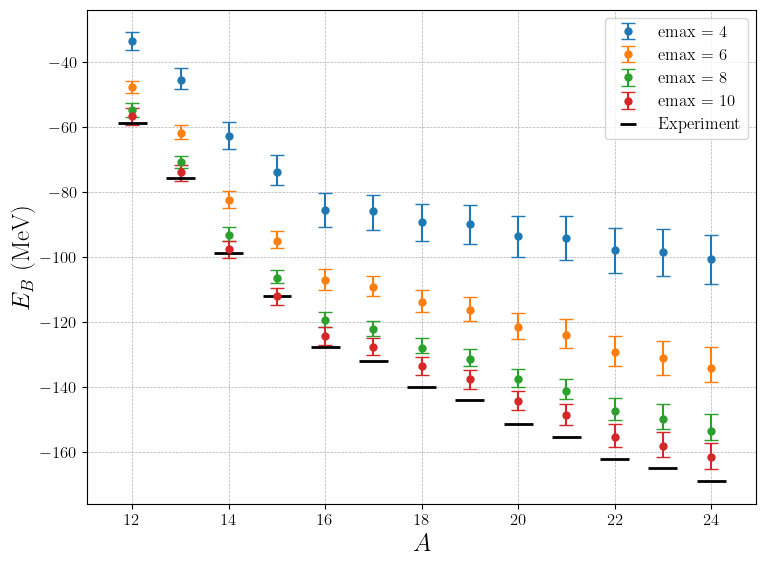

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
As = np.arange(12, 25)
pbar = tqdm([4, 6, 8, 10])
for emax in pbar:
    Eb = []
    uEb = []
    for A in As:
        pbar.set_description(f"O{A}_emax{emax}")
        mean, xmin, xmax = get_dob(samples_df, f"Eb_O{A}_emax{emax}", samples,  error_emulator=np.array(
            samples_df[f'uEb_O{A}_emax{emax}'][samples]))
        Eb.append(mean)
        umin = np.abs(mean - xmin)
        umax = np.abs(mean - xmax)
        uEb.append([umin, umax])
    uEb = np.array(uEb).T
    ax.errorbar(As, Eb, yerr=uEb, fmt='o', label=f"emax = {emax}", capsize=5, markersize=5)

x = np.arange(12, 25)
ax.errorbar(x, experiment, xerr=0.3, label="Experiment",
            color='black', linestyle='none', linewidth=2)
ax.set_xlabel(r'$A$', fontsize=18)
ax.set_ylabel(r'$E_{B}$ (MeV)', fontsize=18)
# ax.set_title('Predicted Energies for Oxygen Isotopes', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show the plot
plt.tight_layout()
plt.savefig("energy_predictions.pdf", bbox_inches='tight')


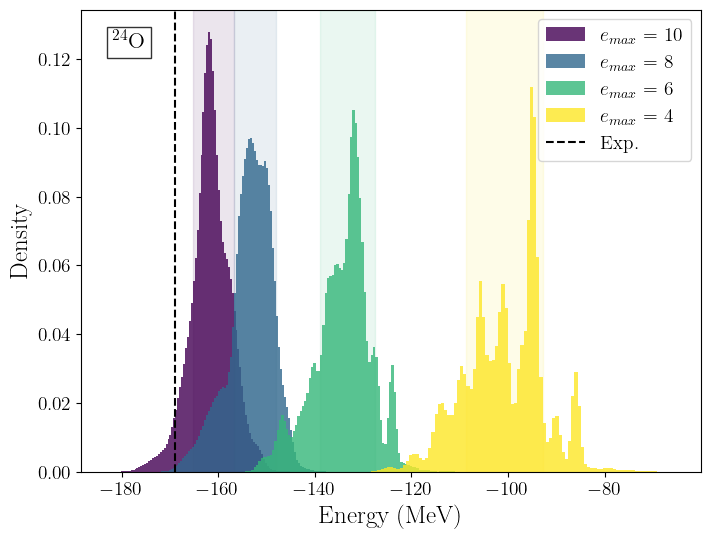

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for emax, col in zip([4, 6, 8, 10][::-1], colors):
    if emax == 4:
        plot_posterior_pdf_hist(ax, samples_df, f"Eb_O24_emax{emax}", samples,
                                error_emulator=np.array(samples_df[f'uEb_O24_emax{emax}'][samples]),
                                confint=0.68, nbins=100, experiment=[experiment[-1], experiment[-1]],
                                exp_label='Exp.', color=col, verbose=False, legend=True, histogram_name=(r"$e_{\max}$"+f" = {emax}"),
                                add_conf_label=False, xlabel='Energy (MeV)', added_text_box=r"$^{{{24}}}$O")
    else:
        plot_posterior_pdf_hist(ax, samples_df, f"Eb_O24_emax{emax}", samples,
                        error_emulator=np.array(samples_df[f'uEb_O24_emax{emax}'][samples]),
                        confint=0.68, nbins=100, experiment=[experiment[-1], experiment[-1]],
                        exp_label='Exp.', color=col, verbose=False, legend=True, histogram_name=(r"$e_{\max}$"+f" = {emax}"), add_exp_label=False, add_conf_label=False, xlabel='Energy (MeV)')

plt.savefig("energy_posterior_distributions.pdf", bbox_inches='tight')

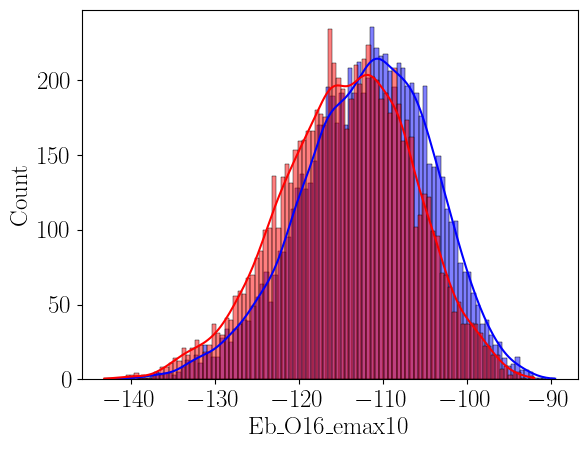

In [18]:
import seaborn as sns
sns.histplot(samples_df['Eb_O16_emax10'], bins=100, kde=True, color='b', alpha=0.5, label='Exp. Data')
sns.histplot(samples_df['16O(E)'], bins=100, kde=True, color='r', alpha=0.5, label='Exp. Data')
plt.show()

### For Charge Radii

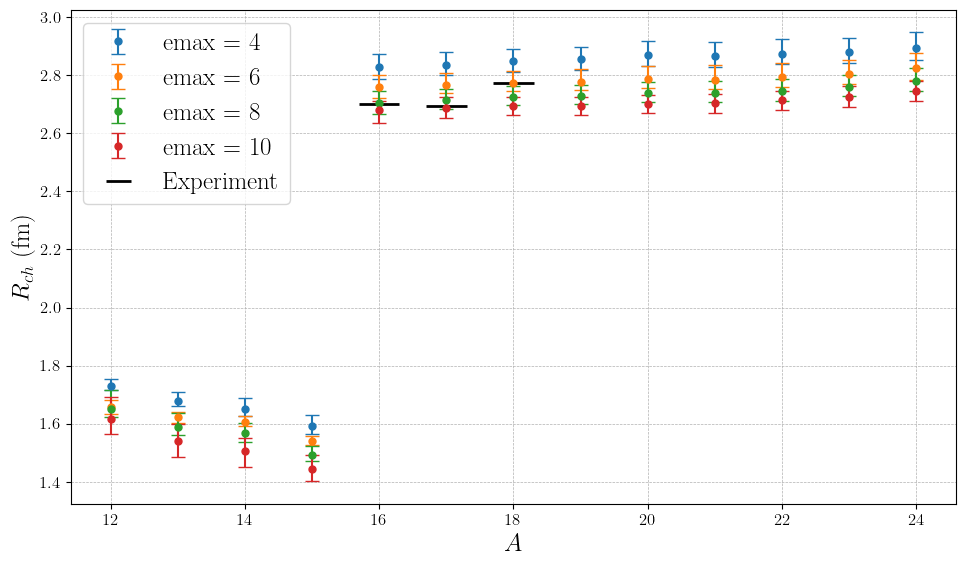

In [19]:
rad_exp = [2.6991, 2.6932, 2.7726]
fig, ax = plt.subplots(figsize=(10, 6))
As = np.arange(12, 25)
for emax in [4, 6, 8, 10]:
    Rch = []
    uRch = []
    for A in As:
        mean, xmin, xmax = get_dob(samples_df, f"Rch_O{A}_emax{emax}", samples,  error_emulator=np.array(
            samples_df[f'uRch_O{A}_emax{emax}'][samples]))
        Rch.append(mean)
        umin = np.abs(mean - xmin)
        umax = np.abs(mean - xmax)
        uRch.append([umin, umax])
    uRch = np.array(uRch).T
    ax.errorbar(As, Rch, yerr=uRch, fmt='o',
                label=f"emax = {emax}", capsize=5, markersize=5)
x = [16,  17, 18]
ax.errorbar(x, rad_exp, xerr=0.3, label="Experiment",
            color='black', linestyle='none', linewidth=2)
ax.set_xlabel(r'$A$', fontsize=18)
ax.set_ylabel(r'$R_{ch}$ (fm)', fontsize=18)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.tight_layout()
plt.legend()
plt.show()


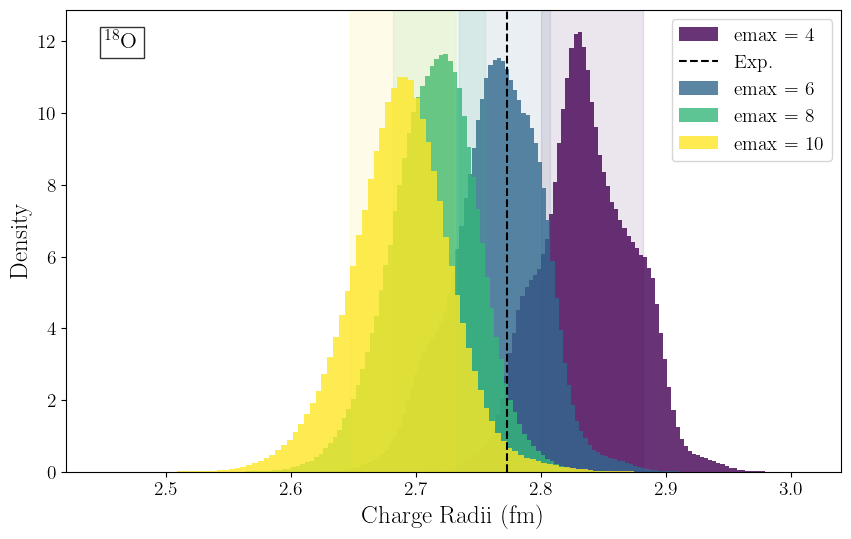

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for emax, col in zip([4, 6, 8, 10], colors):
    if emax==4:
        plot_posterior_pdf_hist(ax, samples_df, f"Rch_O17_emax{emax}", samples, error_emulator=np.array(samples_df[f'uRch_O17_emax{emax}'][samples]), confint=0.68, nbins=100, experiment=[rad_exp[-1], rad_exp[-1]], exp_label='Exp.', color=col, verbose=False, legend=True, histogram_name=f"emax = {emax}", add_conf_label=False, xlabel='Charge Radii (fm)', added_text_box=r"$^{{{18}}}$O")
    else:
        plot_posterior_pdf_hist(ax, samples_df, f"Rch_O17_emax{emax}", samples, error_emulator=np.array(samples_df[f'uRch_O17_emax{emax}'][samples]), confint=0.68, nbins=100, experiment=[rad_exp[-1], rad_exp[-1]], exp_label='Exp.', color=col, verbose=False, legend=True, histogram_name=f"emax = {emax}", add_exp_label=False, add_conf_label=False, xlabel='Charge Radii (fm)')

# Attention and Embeddings

In [22]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_embeddings(model, x, fidelity_idx, Z, N):
    """
    Given a batch of inputs and discrete identifiers, compute the intermediate embeddings.

    Parameters:
        model (HierarchicalBNN): The trained BNN model.
        x (torch.Tensor): Input features.
        fidelity_idx (torch.Tensor): Fidelity indices.
        Z (torch.Tensor): Proton number tensor.
        N (torch.Tensor): Neutron number tensor.

    Returns:
        dict: A dictionary containing the extracted embeddings.
    """
    # Build nuclei embeddings from Z and/or N.
    embeddings_list = []
    if model.config.embed_z:
        embed_z = model.z_embedding(Z)
        embeddings_list.append(embed_z)
    if model.config.embed_n:
        # Use the correct module name: n_encoding_module
        embed_n = model.n_encoding_module(N)
        embeddings_list.append(embed_n)
    if embeddings_list:
        nuclei_embeddings = torch.cat(embeddings_list, dim=-1)
    else:
        nuclei_embeddings = torch.zeros(x.shape[0], 0, device=x.device)

    # Fidelity embedding.
    embed_fidelity = model.fidelity_embedding(fidelity_idx)

    # Concatenate nuclei and fidelity embeddings.
    all_embeddings = torch.cat([nuclei_embeddings, embed_fidelity], dim=-1)

    # Compute the shared latent representation exactly as in the model:
    # 1. Compute the preshared representation from x.
    preshared_representation = model.shared_latent_layer(x)
    # 2. Concatenate the preshared representation with all embeddings.
    in_shared = torch.cat([preshared_representation, all_embeddings], dim=-1)
    # 3. Pass through the multi-head attention.
    att_output, _ = model.attention(
        in_shared.unsqueeze(1),  # Query
        in_shared.unsqueeze(1),  # Key
        in_shared.unsqueeze(1)   # Value
    )
    att_output = att_output.squeeze(1)
    # 4. Apply the projection and add the residual.
    projected_attention = model.attention_residual(att_output)
    shared_representation = projected_attention + preshared_representation

    return {
        "nuclei_embeddings": nuclei_embeddings.detach().cpu().numpy(),
        "shared_representation": shared_representation.detach().cpu().numpy(),
        "fid_embedding": embed_fidelity.detach().cpu().numpy(),
        "att_output": att_output.detach().cpu().numpy(),
    }


def tsne_plot(embeddings, labels, title, save_path, discrete=True, cmap="viridis", legend="Labels"):
    print(f"Computing t-SNE for {title} ...")
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    if discrete:
        unique_labels = np.unique(labels)
        unique_label_names = [f"$^{{{int(l) + 8}}}$O" for l in unique_labels]
        markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X']
        color_map = plt.cm.get_cmap(cmap, len(unique_labels))
        for i, ul in enumerate(unique_labels):
            idx = labels == ul
            plt.scatter(
                emb_2d[idx, 0],
                emb_2d[idx, 1],
                c=[color_map(i)],
                marker=markers[i % len(markers)],
                alpha=0.7,
                edgecolor="k",
                s=50,
                label=unique_label_names[i],
            )
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.legend(title=legend, fontsize=12, loc="best", ncol=2)
        # set axis label font size
    else:
        sc = plt.scatter(
            emb_2d[:, 0], emb_2d[:, 1],
            c=labels, cmap=cmap,
            alpha=0.7, edgecolor="k", s=50
        )
        plt.colorbar(sc)

    plt.xlabel("t-SNE 1", fontsize=14)
    plt.ylabel("t-SNE 2", fontsize=14)
    plt.tight_layout(rect=(0, 0, 0.85, 1))
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to {save_path}")

from sklearn.decomposition import PCA
def plot_3d_pca_embeddings(embeddings, labels, title, save_path):
    """
    Reduce embeddings to 3 dimensions via PCA and create a 3D scatter plot.

    Parameters:
      embeddings (ndarray): The high-dimensional embeddings.
      labels (ndarray): Labels for coloring.
      title (str): Plot title.
      save_path (str): Where to save the plot.
    """
    pca = PCA(n_components=3)
    emb_3d = pca.fit_transform(embeddings)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2],
                   c=labels, cmap='viridis', s=50, edgecolor='k')
    fig.colorbar(p, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    plt.savefig(save_path)
    plt.close(fig)
    print(f"3D PCA plot saved to {save_path}")

def plot_pairplot_embeddings(embeddings, labels, title, save_path):
    """
    Create a pairplot of the dimensions of the nuclei embeddings.
    This is especially useful if the embedding dimension is higher than 1.

    Parameters:
      embeddings (ndarray): The nuclei embeddings.
      labels (ndarray): Labels (e.g., proton number Z).
      title (str): Plot title.
      save_path (str): Where to save the plot.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    df = pd.DataFrame(embeddings, columns=[f"Dim {i+1}" for i in range(embeddings.shape[1])])
    df['Label'] = labels
    sns_plot = sns.pairplot(df, hue="Label", diag_kind="kde", corner=True)
    sns_plot.fig.suptitle(title, y=1.02)
    sns_plot.savefig(save_path)
    # ax.set(xlims=(-40, 40))
    plt.close()
    # set label sizes 18
    plt.tick_params(axis='both', which='major', labelsize=18)
    print(f"Pairplot saved to {save_path}")

def plot_delta_contributions(model, x, fidelity_idx, Z, N, save_path):
    """
    Compute the contribution (delta output) from each fidelity level and plot
    the average norm (over samples) as a bar chart.

    Parameters:
      model: The HierarchicalBNN.
      x, fidelity_idx, Z, N: Input tensors.
      save_path (str): Where to save the plot.
    """
    model.eval()
    with torch.no_grad():
        # Build nuclei embeddings.
        embeddings_list = []
        if model.config.embed_z:
            embed_z = model.z_embedding(Z)
            embeddings_list.append(embed_z)
        if model.config.embed_n:
            embed_n = model.n_encoding_module(N)
            embeddings_list.append(embed_n)
        if embeddings_list:
            nuclei_embeddings = torch.cat(embeddings_list, dim=-1)
        else:
            nuclei_embeddings = torch.zeros(x.shape[0], 0, device=x.device)
        embed_fidelity = model.fidelity_embedding(fidelity_idx)
        all_embeddings = torch.cat([nuclei_embeddings, embed_fidelity], dim=-1)
        preshared_representation = model.shared_latent_layer(x)
        in_shared = torch.cat([preshared_representation, all_embeddings], dim=-1)
        att_output, _ = model.attention(in_shared.unsqueeze(1),
                                        in_shared.unsqueeze(1),
                                        in_shared.unsqueeze(1))
        att_output = att_output.squeeze(1)
        projected_attention = model.attention_residual(att_output)
        shared_representation = projected_attention + preshared_representation

        delta_norms = {}
        for fid_key in model.delta_models.keys():
            delta = model.delta_models[fid_key](shared_representation)
            norm_val = delta.norm(dim=1).mean().item()
            delta_norms[int(fid_key)] = norm_val

    # Plot the average norms as a bar chart.
    sorted_keys = sorted(delta_norms.keys())
    values = [delta_norms[k] for k in sorted_keys]
    plt.figure(figsize=(8, 6))
    plt.bar([str(k) for k in sorted_keys], values, color='skyblue')
    plt.xlabel("Fidelity Level (index)")
    plt.ylabel("Mean Delta Norm")
    plt.title("Average Delta Contribution by Fidelity Level")
    plt.savefig(save_path)
    plt.close()
    print(f"Delta contribution plot saved to {save_path}")

def plot_3d_interactive_pca(embeddings, labels, title):
    """
    Create an interactive 3D PCA scatter plot using Plotly.
    This function will open a browser window.

    Parameters:
      embeddings (ndarray): High-dimensional embeddings.
      labels (ndarray): Labels for coloring.
      title (str): Plot title.
    """
    pca = PCA(n_components=3)
    emb_3d = pca.fit_transform(embeddings)
    import plotly.express as px
    fig = px.scatter_3d(
        x=emb_3d[:, 0],
        y=emb_3d[:, 1],
        z=emb_3d[:, 2],
        color=labels.astype(str),
        title=title,
        labels={"x": "PCA Component 1", "y": "PCA Component 2", "z": "PCA Component 3"}
    )
    fig.show()

def main(model, data, out_dir="../../_results/embeddings", device="cpu"):
    # Set device.
    fidelity_levels = sorted([4, 6, 8, 10])
    model.to(device)
    model.eval()
    print("Model loaded successfully.")

    inputs = torch.tensor(data["inputs"], dtype=torch.float32)
    Z = torch.tensor(data["Z"], dtype=torch.long)
    N = torch.tensor(data["N"], dtype=torch.long)
    fidelity_idx = torch.tensor(data["fidelity_idx"], dtype=torch.long)
    LECs = torch.tensor(data["LECs"], dtype=torch.float32) if "LECs" in data else None

    print(f"Data loaded: {inputs.shape[0]} samples.")

    with torch.no_grad():
        embeddings_dict = get_embeddings(
            model,
            inputs.to(device),
            fidelity_idx.to(device),
            Z.to(device),
            N.to(device)
        )

    # Convert discrete tensors to numpy arrays for plotting.
    N_np = N.cpu().numpy()
    fidelity_np = fidelity_idx.cpu().numpy()
    if LECs is not None:
        LECs_np = LECs.cpu().numpy()
    else:
        LECs_np = None

    os.makedirs(out_dir, exist_ok=True)

    tsne_plot(
        embeddings_dict["shared_representation"],
        N_np,
        "t-SNE of Shared Representation by N",
        os.path.join(out_dir, "tsne_shared_by_N.png"),
    )

    if LECs_np is not None:
        # For illustration, choose the first LEC component.
        tsne_plot(
            LECs_np,
            LECs_np[:, 0],
            "t-SNE of LECs (LEC0)",
            os.path.join(out_dir, "tsne_LECs_by_LEC0.pdf"),
            legend="LEC0"
        )
    else:
        print("No LEC data provided; skipping LEC t-SNE plot.")

    tsne_plot(
        embeddings_dict["att_output"],
        N_np,
        "t-SNE of Attention Output by N",
        "tsne_attention_output_by_N.pdf",
        legend=None
    )

    plot_3d_pca_embeddings(
        embeddings_dict["nuclei_embeddings"],
        N_np,
        "PCA of Nuclei Embeddings",
        os.path.join(out_dir, "pca_nuclei_embeddings_3d.pdf")
    )

    plot_pairplot_embeddings(
        embeddings_dict["nuclei_embeddings"],
        N_np,
        "Pairplot of Nuclei Embeddings",
        os.path.join(out_dir, "pairplot_nuclei_embeddings.pdf")
    )


Model loaded successfully.
Data loaded: 773 samples.
Computing t-SNE for t-SNE of Shared Representation by N ...
Plot saved to ../../../_results/objects/tsne_shared_by_N.png
No LEC data provided; skipping LEC t-SNE plot.
Computing t-SNE for t-SNE of Attention Output by N ...
Plot saved to tsne_attention_output_by_N.pdf
3D PCA plot saved to ../../../_results/objects/pca_nuclei_embeddings_3d.pdf
Pairplot saved to ../../../_results/objects/pairplot_nuclei_embeddings.pdf


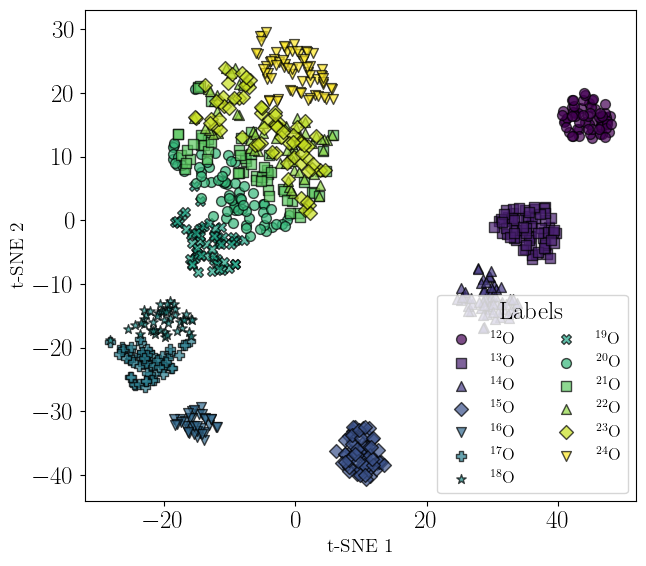

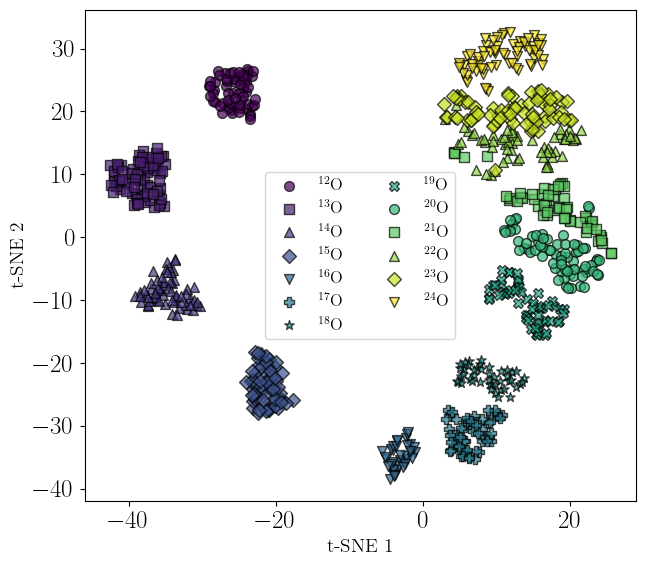

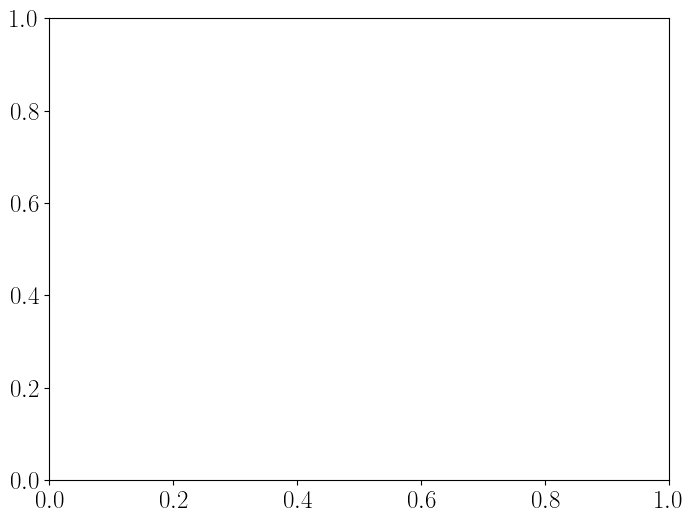

In [23]:
main(best_model, val_datasets[8], out_dir=logs_dir)